In [8]:
!mkdir results

In [9]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy # Add Deepcopy for args
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
partition = {'train': trainset, 'val':valset, 'test':testset}

100%|██████████| 170M/170M [00:02<00:00, 72.3MB/s]


In [11]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim, n_layer, act, dropout, use_bn, use_xavier):
        super(MLP, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_layer = n_layer
        self.act = act
        self.dropout = dropout
        self.use_bn = use_bn
        self.use_xavier = use_xavier

        # ====== Create Linear Layers ====== #
        self.fc1 = nn.Linear(self.in_dim, self.hid_dim)

        self.linears = nn.ModuleList()
        self.bns = nn.ModuleList()
        for i in range(self.n_layer-1):
            self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))
            if self.use_bn:
                self.bns.append(nn.BatchNorm1d(self.hid_dim))

        self.fc2 = nn.Linear(self.hid_dim, self.out_dim)

        # ====== Create Activation Function ====== #
        if self.act == 'relu':
            self.act = nn.ReLU()
        elif self.act == 'tanh':
            self.act == nn.Tanh()
        elif self.act == 'sigmoid':
            self.act = nn.Sigmoid()
        else:
            raise ValueError('no valid activation function selected!')

        # ====== Create Regularization Layer ======= #
        self.dropout = nn.Dropout(self.dropout)
        if self.use_xavier:
            self.xavier_init()

    def forward(self, x):
        x = self.act(self.fc1(x))
        for i in range(len(self.linears)):
            x = self.act(self.linears[i](x))
            if self.use_bn:
                x = self.bns[i](x)
            x = self.dropout(x)
        x = self.fc2(x)
        return x

    def xavier_init(self):
        for linear in self.linears:
            nn.init.xavier_normal_(linear.weight)
            linear.bias.data.fill_(0.01)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = MLP(3072, 10, 100, 4, 'relu', 0.1, True, True) # Testing Model Construction
net.to(device)

MLP(
  (fc1): Linear(in_features=3072, out_features=100, bias=True)
  (linears): ModuleList(
    (0-2): 3 x Linear(in_features=100, out_features=100, bias=True)
  )
  (bns): ModuleList(
    (0-2): 3 x BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (act): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
)

In [12]:
def train(net, partition, optimizer, criterion, args,device):
    trainloader = torch.utils.data.DataLoader(partition['train'],
                                              batch_size=args.train_batch_size,
                                              shuffle=True, num_workers=2)
    net.train()

    correct = 0
    total = 0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        optimizer.zero_grad() # [21.01.05 오류 수정] 매 Epoch 마다 .zero_grad()가 실행되는 것을 매 iteration 마다 실행되도록 수정했습니다.

        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 3072)
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc

In [13]:
def validate(net, partition, criterion, args,device):
    valloader = torch.utils.data.DataLoader(partition['val'],
                                            batch_size=args.test_batch_size,
                                            shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images = images.view(-1, 3072)
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)

            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc

In [14]:
def test(net, partition, args,device):
    testloader = torch.utils.data.DataLoader(partition['test'],
                                             batch_size=args.test_batch_size,
                                             shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.view(-1, 3072)
            images = images.to(device)
            labels = labels.to(device)

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc

In [15]:
def experiment(partition, args,device):

    net = MLP(args.in_dim, args.out_dim, args.hid_dim, args.n_layer, args.act, args.dropout, args.use_bn, args.use_xavier)
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    if args.optim == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        net, train_loss, train_acc = train(net, partition, optimizer, criterion, args,device)
        val_loss, val_acc = validate(net, partition, criterion, args,device)
        te = time.time()

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))

    test_acc = test(net, partition, args, device)

    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result

In [16]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']
    del setting['test_batch_size']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)


def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df


In [17]:
def plot_acc(var1, var2, df):

    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(15, 6)
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    sns.barplot(x=var1, y='train_acc', hue=var2, data=df, ax=ax[0])
    sns.barplot(x=var1, y='val_acc', hue=var2, data=df, ax=ax[1])
    sns.barplot(x=var1, y='test_acc', hue=var2, data=df, ax=ax[2])

    for a in ax:
        for p in a.patches:
            a.annotate(f'{p.get_height():.2f}',
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='bottom', fontsize=10, color='black')


    ax[0].set_title('Train Accuracy')
    ax[1].set_title('Validation Accuracy')
    ax[2].set_title('Test Accuracy')


def plot_loss_variation(var1, var2, df, **kwargs):

    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_losses = list(row.train_losses)[0]
            val_losses = list(row.val_losses)[0]

            for epoch, train_loss in enumerate(train_losses):
                list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_loss in enumerate(val_losses):
                list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'loss', marker='.')
    g.add_legend()
    g.fig.suptitle('Train loss vs Val loss')
    plt.subplots_adjust(top=0.89) # 만약 Title이 그래프랑 겹친다면 top 값을 조정해주면 됩니다! 함수 인자로 받으면 그래프마다 조절할 수 있겠죠?


def plot_acc_variation(var1, var2, df, **kwargs):
    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_accs = list(row.train_accs)[0]
            val_accs = list(row.val_accs)[0]
            test_acc = list(row.test_acc)[0]

            for epoch, train_acc in enumerate(train_accs):
                list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_acc in enumerate(val_accs):
                list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

    def show_acc(x, y, metric, **kwargs):
        plt.scatter(x, y, alpha=0.3, s=1)
        metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
        plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
    g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

    g.add_legend()
    g.fig.suptitle('Train Accuracy vs Val Accuracy')
    plt.subplots_adjust(top=0.89)

In [18]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_n_layer_hid_dim"

# ====== Model Capacity ====== #
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 100
args.act = 'relu'

# ====== Regularization ======= #
args.dropout = 0.2
args.use_bn = True
args.l2 = 0.00001
args.use_xavier = True

# ====== Optimizer & Training ====== #
args.optim = 'RMSprop' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0015
args.epoch = 10

args.train_batch_size = 256
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'n_layer'
name_var2 = 'hid_dim'
list_var1 = [1, 2, 3]
list_var2 = [500, 300]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)

        setting, result = experiment(partition, deepcopy(args),device)
        save_exp_result(setting, result)

Namespace(exp_name='exp1_n_layer_hid_dim', in_dim=3072, out_dim=10, hid_dim=500, act='relu', dropout=0.2, use_bn=True, l2=1e-05, use_xavier=True, optim='RMSprop', lr=0.0015, epoch=10, train_batch_size=256, test_batch_size=1024, n_layer=1)


KeyboardInterrupt: 

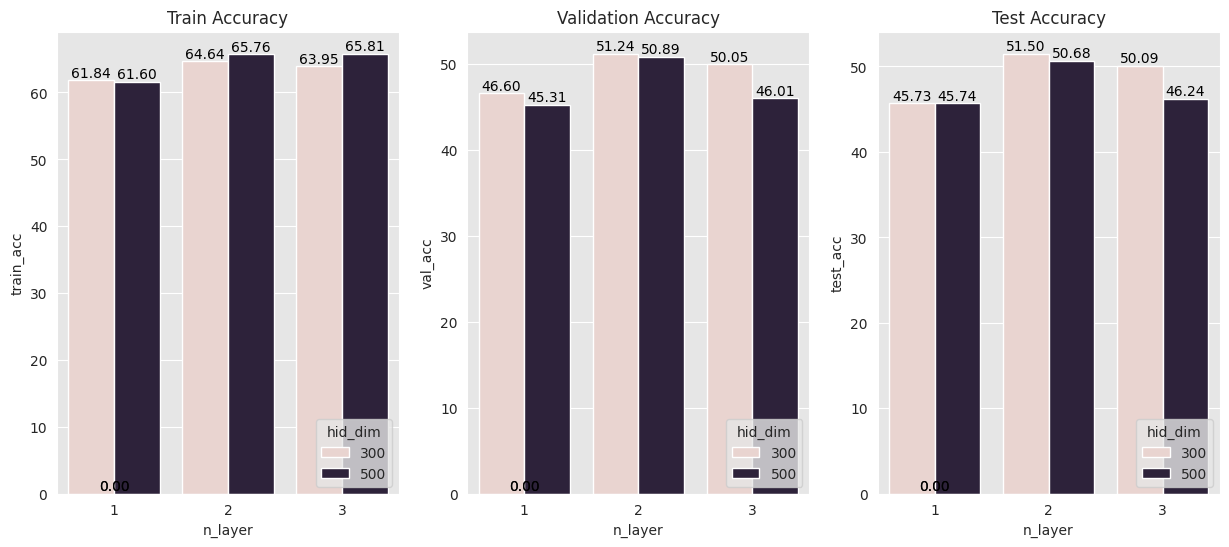

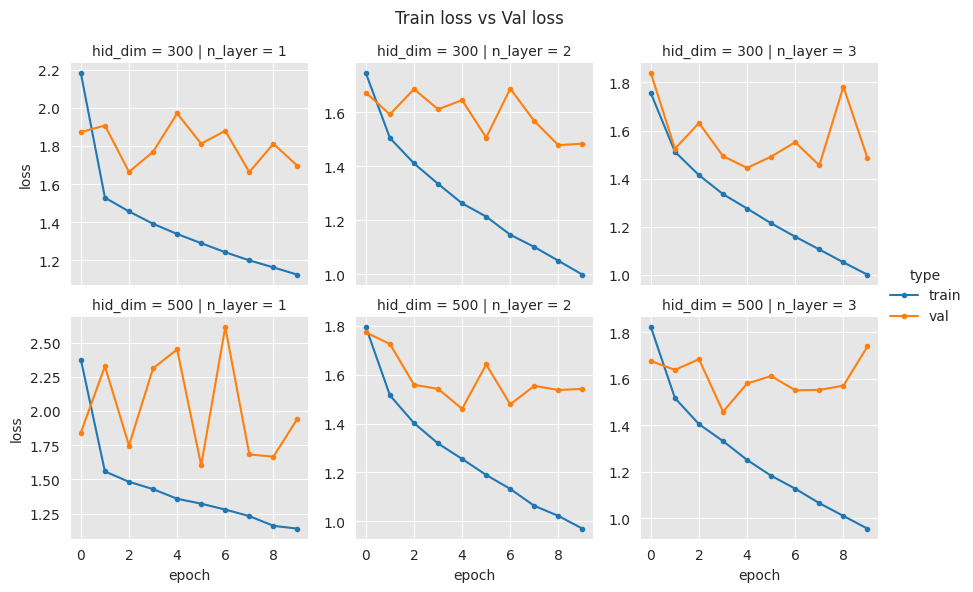

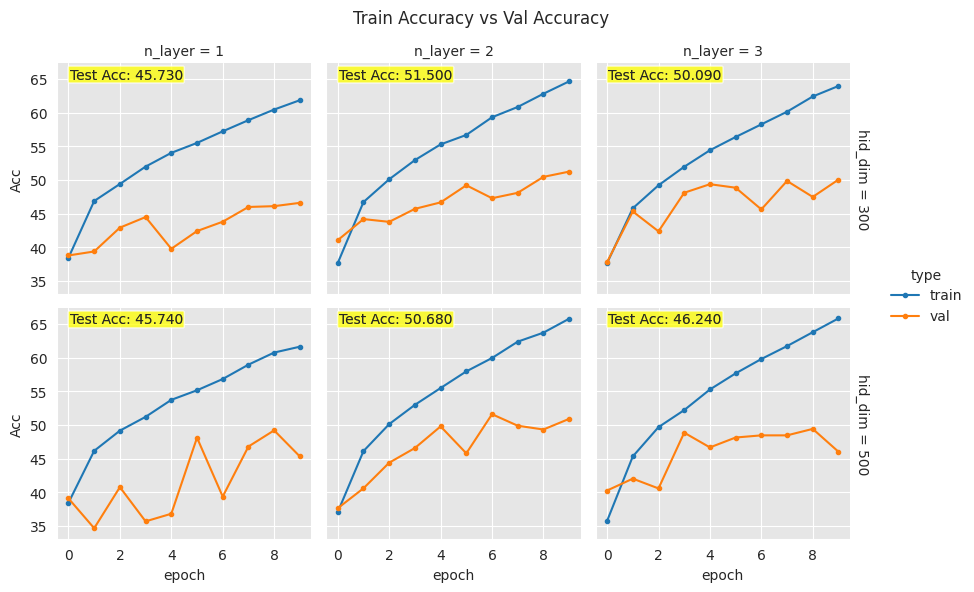

In [ ]:
var1 = 'n_layer'
var2 = 'hid_dim'
df = load_exp_result('exp1')

plot_acc(var1, var2, df)
plot_loss_variation(var1, var2, df, sharey=False) #sharey를 True로 하면 모둔 subplot의 y축의 스케일이 같아집니다.
plot_acc_variation(var1, var2, df, margin_titles=True, sharey=True) #margin_titles를 True로 하면 그래프의 가장자리에 var1과 var2 값이 표시되고 False로 하면 각 subplot 위에 표시됩니다.

# 1.레이어, 히든 유닛 수 조정
 ### train acc에 비해  val acc가 너무 낮아서 과적합이 일어났으므로 레이어를 줄이고 hid_dim을 줄여야 함



In [ ]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_n_layer_hid_dim"

# ====== Model Capacity ====== #
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 100
args.act = 'relu'

# ====== Regularization ======= #
args.dropout = 0.2
args.use_bn = True
args.l2 = 0.00001
args.use_xavier = True

# ====== Optimizer & Training ====== #
args.optim = 'RMSprop' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0015
args.epoch = 10

args.train_batch_size = 256
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'n_layer'
name_var2 = 'hid_dim'
list_var1 = [1, 2]
list_var2 = [100,200,300]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)

        setting, result = experiment(partition, deepcopy(args),device)
        save_exp_result(setting, result)


        ##이거 결과 맟춰서 레이어랑 수 바꿔주고 밑에 수정 한꺼버에 함

Namespace(exp_name='exp1_n_layer_hid_dim', in_dim=3072, out_dim=10, hid_dim=100, act='relu', dropout=0.2, use_bn=True, l2=1e-05, use_xavier=True, optim='RMSprop', lr=0.0015, epoch=10, train_batch_size=256, test_batch_size=1024, n_layer=1)
Epoch 0, Acc(train/val): 38.60/38.87, Loss(train/val) 1.88/1.74. Took 15.95 sec
Epoch 1, Acc(train/val): 46.45/42.01, Loss(train/val) 1.52/1.66. Took 15.71 sec
Epoch 2, Acc(train/val): 49.33/42.17, Loss(train/val) 1.45/1.71. Took 23.94 sec
Epoch 3, Acc(train/val): 51.68/41.19, Loss(train/val) 1.39/1.76. Took 16.80 sec
Epoch 4, Acc(train/val): 53.17/42.73, Loss(train/val) 1.34/1.72. Took 16.17 sec
Epoch 5, Acc(train/val): 54.63/41.82, Loss(train/val) 1.30/1.77. Took 16.13 sec
Epoch 6, Acc(train/val): 56.04/45.43, Loss(train/val) 1.27/1.63. Took 16.20 sec
Epoch 7, Acc(train/val): 56.96/44.86, Loss(train/val) 1.24/1.70. Took 17.82 sec
Epoch 8, Acc(train/val): 58.30/44.92, Loss(train/val) 1.21/1.64. Took 16.06 sec
Epoch 9, Acc(train/val): 59.48/47.52, Los

In [ ]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']
    del setting['test_batch_size']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)


def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df


In [ ]:
def plot_acc(var1, var2, df):

    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(15, 6)
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    sns.barplot(x=var1, y='train_acc', hue=var2, data=df, ax=ax[0])
    sns.barplot(x=var1, y='val_acc', hue=var2, data=df, ax=ax[1])
    sns.barplot(x=var1, y='test_acc', hue=var2, data=df, ax=ax[2])

    for a in ax:
        for p in a.patches:
            a.annotate(f'{p.get_height():.2f}',
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='bottom', fontsize=10, color='black')


    ax[0].set_title('Train Accuracy')
    ax[1].set_title('Validation Accuracy')
    ax[2].set_title('Test Accuracy')


def plot_loss_variation(var1, var2, df, **kwargs):

    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_losses = list(row.train_losses)[0]
            val_losses = list(row.val_losses)[0]

            for epoch, train_loss in enumerate(train_losses):
                list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_loss in enumerate(val_losses):
                list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'loss', marker='.')
    g.add_legend()
    g.fig.suptitle('Train loss vs Val loss')
    plt.subplots_adjust(top=0.89) # 만약 Title이 그래프랑 겹친다면 top 값을 조정해주면 됩니다! 함수 인자로 받으면 그래프마다 조절할 수 있겠죠?


def plot_acc_variation(var1, var2, df, **kwargs):
    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]
            if row.empty:
               continue

            train_accs = list(row.train_accs)[0]
            val_accs = list(row.val_accs)[0]
            test_acc = list(row.test_acc)[0]

            for epoch, train_acc in enumerate(train_accs):
                list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_acc in enumerate(val_accs):
                list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

    def show_acc(x, y, metric, **kwargs):
        plt.scatter(x, y, alpha=0.3, s=1)
        metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
        plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
    g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

    g.add_legend()
    g.fig.suptitle('Train Accuracy vs Val Accuracy')
    plt.subplots_adjust(top=0.89)

mkdir: cannot create directory ‘results’: File exists


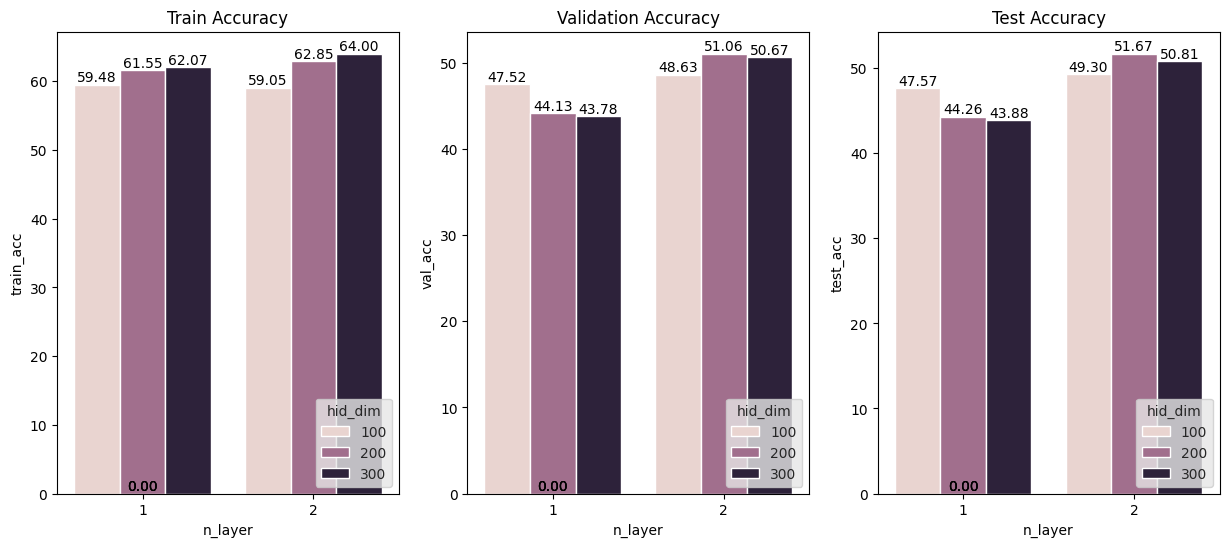

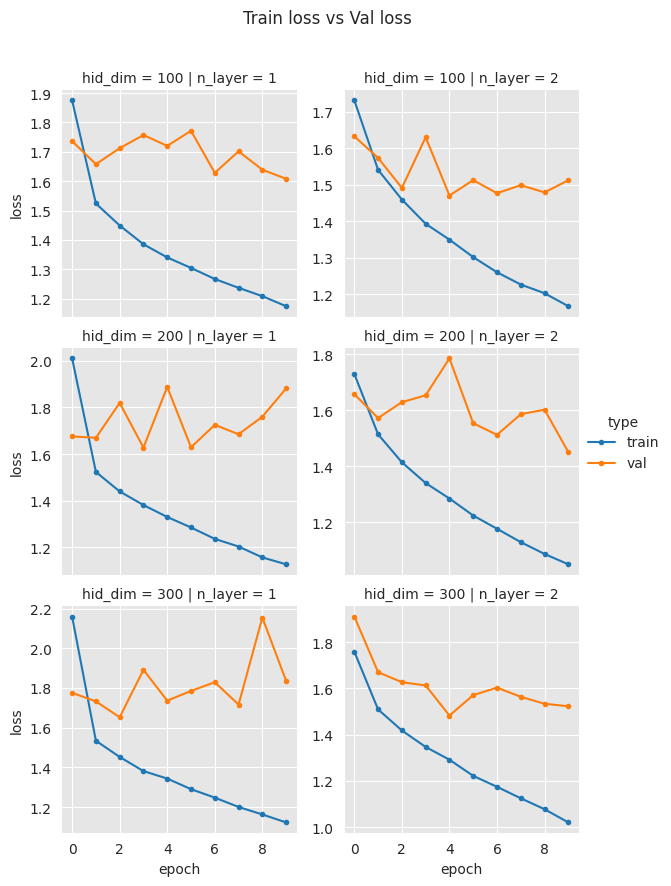

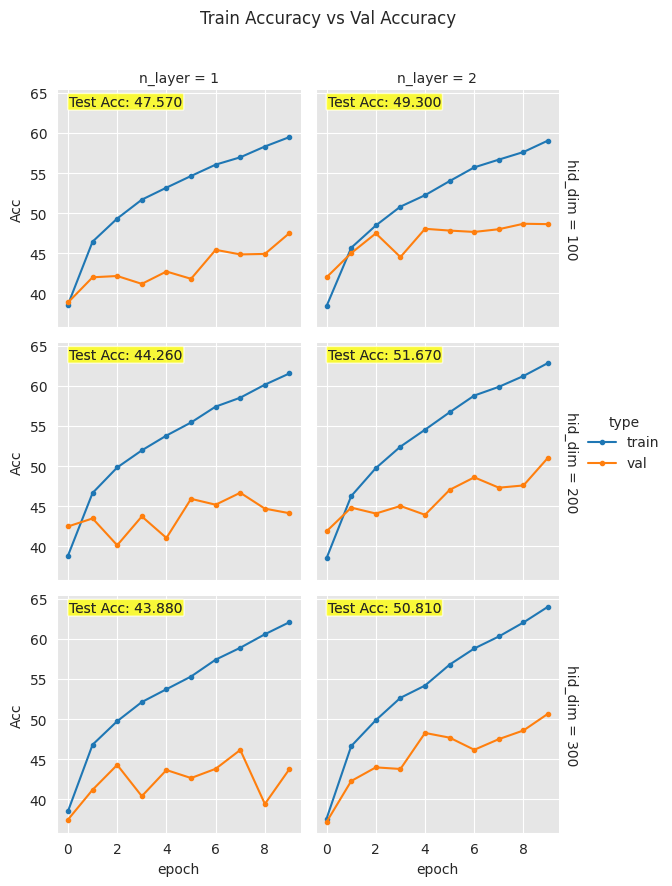

In [ ]:
!mkdir results
var1 = 'n_layer'
var2 = 'hid_dim'
df = load_exp_result('exp1')

plot_acc(var1, var2, df)
plot_loss_variation(var1, var2, df, sharey=False) #sharey를 True로 하면 모둔 subplot의 y축의 스케일이 같아집니다.
plot_acc_variation(var1, var2, df, margin_titles=True, sharey=True) #margin_titles를 True로 하면 그래프의 가장자리에 var1과 var2 값이 표시되고 False로 하면 각 subplot 위에 표시됩니다.

#2.lr 조정하기/dropout,l2 조정
### 전반적으로 훈련 데이터에서는 손실이 점진적으로 감소하는데 val loss는 급격하게 감소하거나 증가함->학습률을 줄이거나 적합한 학습률 찾기

In [12]:
import torch.optim as optim
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim, n_layer, act, dropout, use_bn, use_xavier, lr=0.0015):
        super(MLP, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_layer = n_layer
        self.act = act
        self.dropout = dropout
        self.use_bn = use_bn
        self.use_xavier = use_xavier

        # ====== Create Linear Layers ====== #
        self.fc1 = nn.Linear(self.in_dim, self.hid_dim)

        self.linears = nn.ModuleList()
        self.bns = nn.ModuleList()
        for i in range(self.n_layer-1):
            self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))
            if self.use_bn:
                self.bns.append(nn.BatchNorm1d(self.hid_dim))

        self.fc2 = nn.Linear(self.hid_dim, self.out_dim)

        # ====== Create Activation Function ====== #
        if self.act == 'relu':
            self.act = nn.ReLU()
        elif self.act == 'tanh':
            self.act = nn.Tanh()
        elif self.act == 'sigmoid':
            self.act = nn.Sigmoid()
        else:
            raise ValueError('no valid activation function selected!')

        # ====== Create Regularization Layer ======= #
        self.dropout = nn.Dropout(self.dropout)
        if self.use_xavier:
            self.xavier_init()

        # ====== Optimizer and Scheduler ====== #
        self.optimizer = optim.RMSprop(self.parameters(), lr=lr)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=1, gamma=0.0001)#학습률을 특정 주기로 감소시킴

    def forward(self, x):
        x = self.act(self.fc1(x))
        for i in range(len(self.linears)):
            x = self.act(self.linears[i](x))
            if self.use_bn:
                x = self.bns[i](x)
            x = self.dropout(x)
        x = self.fc2(x)
        return x

    def xavier_init(self):
        for linear in self.linears:
            nn.init.xavier_normal_(linear.weight)
            linear.bias.data.fill_(0.01)

# 예시로 모델을 생성
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = MLP(3072, 10, 100, 4, 'relu', 0.1, True, True) # 모델 생성
net.to(device)

# 모델과 옵티마이저 확인
print(net.optimizer)


RMSprop (
Parameter Group 0
    alpha: 0.99
    capturable: False
    centered: False
    differentiable: False
    eps: 1e-08
    foreach: None
    initial_lr: 0.0015
    lr: 0.0015
    maximize: False
    momentum: 0
    weight_decay: 0
)


In [13]:
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp2"

# ====== Model Capacity ====== #
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 100
args.n_layer=2

args.act = 'relu'

# ====== Regularization ======= #
args.dropout = 0.3 #드롭아웃 값 올리기(과적합 방지)
args.use_bn = True
args.l2 = 0.00007 #가중치 값 올리기(과적합 방지)
args.use_xavier = True

# ====== Optimizer & Training ====== #
args.optim = 'RMSprop' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0015
args.epoch = 10

args.train_batch_size = 256
args.test_batch_size = 1024

# Create an instance of the MLP model
model = MLP(args.in_dim, args.out_dim, args.hid_dim, args.n_layer, args.act, args.dropout, args.use_bn, args.use_xavier) # instantiate the model


setting, result = experiment( partition, deepcopy(args),device) # Pass the model instance to experiment
save_exp_result(setting, result)




Epoch 0, Acc(train/val): 37.40/39.71, Loss(train/val) 1.75/1.75. Took 21.70 sec
Epoch 1, Acc(train/val): 44.91/45.94, Loss(train/val) 1.56/1.54. Took 15.53 sec
Epoch 2, Acc(train/val): 47.76/46.33, Loss(train/val) 1.48/1.51. Took 15.36 sec
Epoch 3, Acc(train/val): 49.72/48.23, Loss(train/val) 1.42/1.47. Took 15.37 sec
Epoch 4, Acc(train/val): 51.35/47.46, Loss(train/val) 1.38/1.47. Took 16.79 sec
Epoch 5, Acc(train/val): 52.62/49.27, Loss(train/val) 1.34/1.43. Took 16.38 sec
Epoch 6, Acc(train/val): 53.68/46.35, Loss(train/val) 1.30/1.51. Took 16.79 sec
Epoch 7, Acc(train/val): 54.70/46.90, Loss(train/val) 1.28/1.53. Took 17.12 sec
Epoch 8, Acc(train/val): 55.81/49.66, Loss(train/val) 1.25/1.44. Took 15.64 sec
Epoch 9, Acc(train/val): 56.71/49.98, Loss(train/val) 1.22/1.42. Took 15.90 sec


### 이 값에서 각각의 옵티마이저 종류와 자비에 초기화,배치 정규화를 사용했을 깨의 그래프 변화

In [19]:
# 실험 실행 함수
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy # Add Deepcopy for args
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

def experiment(model, partition, args, device):
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    if args.optim == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')



    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(args.epoch):
        ts = time.time()
        model, train_loss, train_acc = train(model, partition, optimizer, criterion, args, device)
        val_loss, val_acc = validate(model, partition, criterion, args, device)
        te = time.time()

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f'Epoch {epoch}, Acc(train/val): {train_acc:.2f}/{val_acc:.2f}, Loss(train/val): {train_loss:.2f}/{val_loss:.2f}. Took {te-ts:.2f} sec')

    test_acc = test(model, partition, args, device)

    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result

# 실험을 위한 기본 설정
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp2_batch_xavier_optimizer"

# ====== Model Capacity ====== #
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 100
args.n_layer = 2
args.act = 'relu'

# ====== Regularization ======= #
args.dropout = 0.3  # 드롭아웃 값
args.l2 = float(0.00007)   # L2 정규화
args.use_xavier = True  # 자비에 초기화 여부

# ====== Optimizer & Training ====== #
args.lr = float(0.0015)
args.epoch = int(10)
args.train_batch_size = int(256)
args.test_batch_size = int(1024)

# 옵티마이저 종류들
optimizers = ['SGD', 'RMSprop', 'Adam']

# 배치 정규화, 자비에 초기화 여부 조합 생성
bn_choices = [True, False]
xavier_choices = [True, False]

# 모든 가능한 조합을 생성
combinations = list(itertools.product(bn_choices, xavier_choices))

# 각 조합에 대해 실험 수행

results_list = []
for optim_type in optimizers:
    for use_bn, use_xavier in combinations:
        # 각 조합 설정
        args.use_bn = use_bn
        args.use_xavier = use_xavier
        args.optim = optim_type  # 이 부분에서 optimizer 설정을 추가해야 합니다.

        print(f"Running experiment with {optim_type}, BN={use_bn}, Xavier={use_xavier}")

        # 모델을 초기화하고 실험 실행
        # Remove optim_type as the lr argument:
        model = MLP(args.in_dim, args.out_dim, args.hid_dim, args.n_layer, args.act, args.dropout, args.use_bn, args.use_xavier)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # partition을 데이터셋으로 변경
        partition = {
            'train': trainset,
            'val': valset,
            'test': testset
        }

        # 실험 실행
        setting, result = experiment(model, partition, deepcopy(args), device)
        save_exp_result(setting, result)

        results_list.append(result)


#생각해보니까 이건 다시 안해도 되는데 걍 그래프만 수정하고 위에 결과 아 나오는 애들만 다시 해준다음 바꿔도 될듯행


Running experiment with SGD, BN=True, Xavier=True
Epoch 0, Acc(train/val): 23.44/32.00, Loss(train/val): 2.13/1.92. Took 14.80 sec
Epoch 1, Acc(train/val): 32.64/36.40, Loss(train/val): 1.91/1.81. Took 17.11 sec
Epoch 2, Acc(train/val): 35.70/38.68, Loss(train/val): 1.83/1.76. Took 14.93 sec
Epoch 3, Acc(train/val): 37.74/40.31, Loss(train/val): 1.77/1.73. Took 14.90 sec
Epoch 4, Acc(train/val): 39.22/40.59, Loss(train/val): 1.74/1.70. Took 15.40 sec
Epoch 5, Acc(train/val): 40.56/41.68, Loss(train/val): 1.70/1.68. Took 15.00 sec
Epoch 6, Acc(train/val): 41.63/42.52, Loss(train/val): 1.68/1.66. Took 14.81 sec
Epoch 7, Acc(train/val): 42.38/42.94, Loss(train/val): 1.66/1.64. Took 14.93 sec
Epoch 8, Acc(train/val): 43.30/43.32, Loss(train/val): 1.63/1.63. Took 15.57 sec
Epoch 9, Acc(train/val): 44.00/43.98, Loss(train/val): 1.62/1.61. Took 15.63 sec
Running experiment with SGD, BN=True, Xavier=False
Epoch 0, Acc(train/val): 23.79/32.84, Loss(train/val): 2.12/1.92. Took 15.64 sec
Epoch 1,

In [21]:
def save_exp_result(setting, result):
    print("저장되는 setting:", setting)
    print("저장되는 result:", result)  # 결과를 출력해서 확인
    # 실제 저장하는 코드가 있다면 여기에 위치


In [22]:
print(f"args.lr type: {type(args.lr)}, value: {args.lr}")
print(f"args.l2 type: {type(args.l2)}, value: {args.l2}")


args.lr type: <class 'float'>, value: 0.0015
args.l2 type: <class 'float'>, value: 7e-05


In [ ]:
print(f"optim_type: {optim_type}, type: {type(optim_type)}")


optim_type: SGD, type: <class 'str'>


각 옵티마이저당 각 경우에 ㅏㄸ랏 전부 그래프를 만들 수 밖에 없을 것 가타용

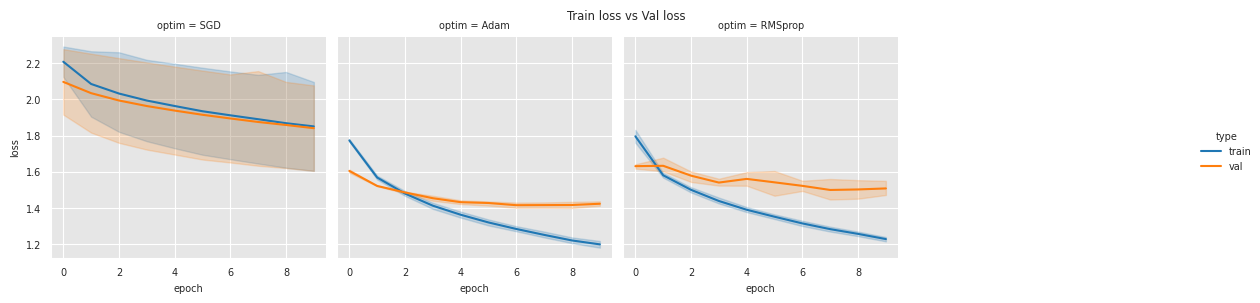

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

var1 = 'optim'
var2 =  'use_bn'
var3 = 'use_xavier'

df = load_exp_result('exp2')

list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_v3 = df[var3].unique()
list_data = []

# 각 변수 값에 대해 데이터 필터링
for value1 in list_v1:
    for value2 in list_v2:
        for value3 in list_v3:  # var3에 따른 반복문 추가
            row = df.loc[df[var1] == value1]
            row = row.loc[df[var2] == value2]
            row = row.loc[df[var3] == value3]  # var3에 해당하는 데이터만 필터링

            # 손실 값 추출
            train_losses = list(row['train_losses'])[0]
            val_losses = list(row['val_losses'])[0]

            # train_losses와 val_losses 저장
            for epoch, train_loss in enumerate(train_losses):
                list_data.append({'type': 'train', 'loss': train_loss, 'epoch': epoch, var1: value1, var2: value2, var3: value3})
            for epoch, val_loss in enumerate(val_losses):
                list_data.append({'type': 'val', 'loss': val_loss, 'epoch': epoch, var1: value1, var2: value2, var3: value3})

# 새로운 데이터프레임 생성
df = pd.DataFrame(list_data)

# FacetGrid로 손실 값 시각화 (lineplot)
g = sns.FacetGrid(df, col=var1, hue='type', col_wrap=4)  # col_wrap을 var2에만 적용
g = g.map(sns.lineplot, 'epoch', 'loss')  # lineplot으로 수정
g.add_legend()
g.fig.suptitle('Train loss vs Val loss')

# 제목이 겹치지 않도록 조정
plt.subplots_adjust(top=0.89)  # 그래프의 제목과 겹치지 않도록 조정

plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

var1 = 'optim'
var2 =  'use_bn'
var3 = 'use_xavier'

df = load_exp_result('exp2')

list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_v3 = df[var3].unique()
list_data = []

# 각 변수 값에 대해 데이터 필터링
for value1 in list_v1:
    for value2 in list_v2:
        for value3 in list_v3:  # var3에 따른 반복문 추가
            row = df.loc[df[var1] == value1]
            row = row.loc[df[var2] == value2]
            row = row.loc[df[var3] == value3]  # var3에 해당하는 데이터만 필터링

            # 손실 값 추출
            train_losses = list(row['train_losses'])[0]
            val_losses = list(row['val_losses'])[0]

            # train_losses와 val_losses 저장
            for epoch, train_loss in enumerate(train_losses):
                list_data.append({'type': 'train', 'loss': train_loss, 'epoch': epoch, var1: value1, var2: value2, var3: value3})
            for epoch, val_loss in enumerate(val_losses):
                list_data.append({'type': 'val', 'loss': val_loss, 'epoch': epoch, var1: value1, var2: value2, var3: value3})

# 새로운 데이터프레임 생성
df = pd.DataFrame(list_data)

# FacetGrid로 손실 값 시각화 (lineplot)
g = sns.FacetGrid(df, col=var1, hue='type', col_wrap=4)  # col_wrap을 var2에만 적용
g = g.map(sns.lineplot, 'epoch', 'loss')  # lineplot으로 수정
g.add_legend()
g.fig.suptitle('Train loss vs Val loss')

# 제목이 겹치지 않도록 조정
plt.subplots_adjust(top=0.89)  # 그래프의 제목과 겹치지 않도록 조정

plt.show()

In [54]:
df = load_exp_result('exp2')
print(df.columns)  # df의 열 이름을 확인


Index(['train_losses', 'val_losses', 'train_accs', 'val_accs', 'train_acc',
       'val_acc', 'test_acc', 'exp_name', 'in_dim', 'out_dim', 'hid_dim',
       'n_layer', 'act', 'dropout', 'l2', 'use_xavier', 'lr',
       'train_batch_size', 'use_bn', 'optim'],
      dtype='object')


In [58]:
def plot_acc_variation(var1, var2, var3, df, **kwargs):
    list_v1 = df[var1].unique()  # var1에 대한 고유 값들
    list_v2 = df[var2].unique()  # var2에 대한 고유 값들
    list_v3 = df[var3].unique()  # var3에 대한 고유 값들
    list_data = []

    # 각 변수 값들에 대해 반복하면서 데이터 필터링
    for value1 in list_v1:
        for value2 in list_v2:
            for value3 in list_v3:  # var3 추가
                row = df.loc[df[var1] == value1]
                row = row.loc[df[var2] == value2]
                row = row.loc[df[var3] == value3]  # var3에 대한 필터링 추가

                if row.empty:
                    continue

                train_accs = list(row.train_accs)[0]
                val_accs = list(row.val_accs)[0]
                test_acc = list(row.test_acc)[0]

                for epoch, train_acc in enumerate(train_accs):
                    list_data.append({'type': 'train', 'Acc': train_acc, 'test_acc': test_acc, 'epoch': epoch, var1: value1, var2: value2, var3: value3})
                for epoch, val_acc in enumerate(val_accs):
                    list_data.append({'type': 'val', 'Acc': val_acc, 'test_acc': test_acc, 'epoch': epoch, var1: value1, var2: value2, var3: value3})

    # 데이터를 데이터프레임으로 변환
    df = pd.DataFrame(list_data)

    # FacetGrid로 var1, var2에 대한 그래프를 그리되, var3에 따라 구분
    g = sns.FacetGrid(df, col=var1, row=var2, hue='type', col_wrap=4, **kwargs)  # col_wrap을 var1에만 적용
    g = g.map(sns.lineplot, 'epoch', 'Acc', marker='.')

    # test_acc 표시 함수
    def show_acc(x, y, metric, **kwargs):
        plt.scatter(x, y, alpha=0.3, s=1)
        metric = "Test Acc: {:1.3f}".format(metric)  # 수정된 부분
        plt.text(0.1, 0.95, metric, horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))

    g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

    g.add_legend()
    g.fig.suptitle('Train Accuracy vs Val Accuracy')
    plt.subplots_adjust(top=0.89)  # 제목이 그래프와 겹치지 않도록 조정

    plt.show()